<a id="2"></a>
<h1 style="background-color:#deface; font-family: 'New Timeroman', cursive; color:#082a40; font-size:170%; text-align:center; border-radius:30px; padding:10px;">
  RSNA Intracranial Aneurysm Detection
</h1>

> Accurate and timely diagnosis is critical in healthcare, especially for potentially life-threatening medical conditions like brain aneurysms. Brain aneurysms (or intracranial aneurysms) are focal dilations in the arteries of the brain that may not show symptoms initially but can be deadly if not diagnosed accurately and treated appropriately.

> Experienced radiologists can detect aneurysms on images of the brain, but they can be easily overlooked, particularly when imaging studies are performed for other purposes. Rapid and accurate automated detection of aneurysms on routine brain imaging studies could help prevent devastating outcomes for patients.

> ## A Beginner's Guide to Data Analysis
This notebook provides a comprehensive exploration of the RSNA Intracranial Aneurysm Detection competition data and builds a simple baseline model. <br>
**Competition Goal:** Detect and locate intracranial aneurysms in multimodal brain imaging data (CTA, MRA, MRI).

## 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from tqdm.notebook import tqdm
import nibabel as nib  # For NifTI files
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set paths - adjust these to match your environment
DATA_DIR = '../input/rsna-intracranial-aneurysm-detection/'
TRAIN_CSV = os.path.join(DATA_DIR, 'train.csv')
TRAIN_LOCALIZERS_CSV = os.path.join(DATA_DIR, 'train_localizers.csv')
SERIES_DIR = os.path.join(DATA_DIR, 'series')
SEGMENTATIONS_DIR = os.path.join(DATA_DIR, 'segmentations')

In [2]:
# Load training data
train_df = pd.read_csv(TRAIN_CSV)
localizers_df = pd.read_csv(TRAIN_LOCALIZERS_CSV)

print(f"Training data shape: {train_df.shape}")
print(f"Localizers data shape: {localizers_df.shape}")

# Display first few rows of each dataframe
print("\nTraining Data Sample:")
display(train_df.head())

print("\nLocalizers Data Sample:")
display(localizers_df.head())

Training data shape: (4348, 18)
Localizers data shape: (2254, 4)

Training Data Sample:


,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
0,1.2.826.0.1.3680043.8.498.10004044428023505108...,64,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.10004684224894397679...,76,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.10005158603912009425...,58,Male,CTA,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,1.2.826.0.1.3680043.8.498.10009383108068795488...,71,Male,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.10012790035410518400...,48,Female,MRA,0,0,0,0,0,0,0,0,0,0,0,0,0,0



Localizers Data Sample:


,SeriesInstanceUID,SOPInstanceUID,coordinates,location
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,"{'x': 258.3621186176837, 'y': 261.359900373599}",Other Posterior Circulation
1,1.2.826.0.1.3680043.8.498.10022796280698534221...,1.2.826.0.1.3680043.8.498.53868409774237283281...,"{'x': 194.87253141831238, 'y': 178.32675044883...",Right Middle Cerebral Artery
2,1.2.826.0.1.3680043.8.498.10023411164590664678...,1.2.826.0.1.3680043.8.498.24186535344744886473...,"{'x': 189.23979878597123, 'y': 209.19184886465...",Right Middle Cerebral Artery
3,1.2.826.0.1.3680043.8.498.10030095840917973694...,1.2.826.0.1.3680043.8.498.75217084841854214544...,"{'x': 208.2805049088359, 'y': 229.78962131837307}",Right Infraclinoid Internal Carotid Artery
4,1.2.826.0.1.3680043.8.498.10034081836061566510...,1.2.826.0.1.3680043.8.498.71237104731452368587...,"{'x': 249.86745590416498, 'y': 220.623044646393}",Anterior Communicating Artery


## 2. Exploratory Data Analysis (EDA)

In [3]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())

# Display basic info about training data
train_df.info()

Missing values in training data:
SeriesInstanceUID                             0
PatientAge                                    0
PatientSex                                    0
Modality                                      0
Left Infraclinoid Internal Carotid Artery     0
Right Infraclinoid Internal Carotid Artery    0
Left Supraclinoid Internal Carotid Artery     0
Right Supraclinoid Internal Carotid Artery    0
Left Middle Cerebral Artery                   0
Right Middle Cerebral Artery                  0
Anterior Communicating Artery                 0
Left Anterior Cerebral Artery                 0
Right Anterior Cerebral Artery                0
Left Posterior Communicating Artery           0
Right Posterior Communicating Artery          0
Basilar Tip                                   0
Other Posterior Circulation                   0
Aneurysm Present                              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4348 entries, 0 to 4347
Data columns (to

In [4]:
# Examine distribution of aneurysms
print(f"Total number of cases: {len(train_df)}")
print(f"Cases with aneurysms: {train_df['Aneurysm Present'].sum()} ({train_df['Aneurysm Present'].mean()*100:.2f}%)")
print(f"Cases without aneurysms: {len(train_df) - train_df['Aneurysm Present'].sum()} ({(1-train_df['Aneurysm Present'].mean())*100:.2f}%)")

Total number of cases: 4348
Cases with aneurysms: 1863 (42.85%)
Cases without aneurysms: 2485 (57.15%)


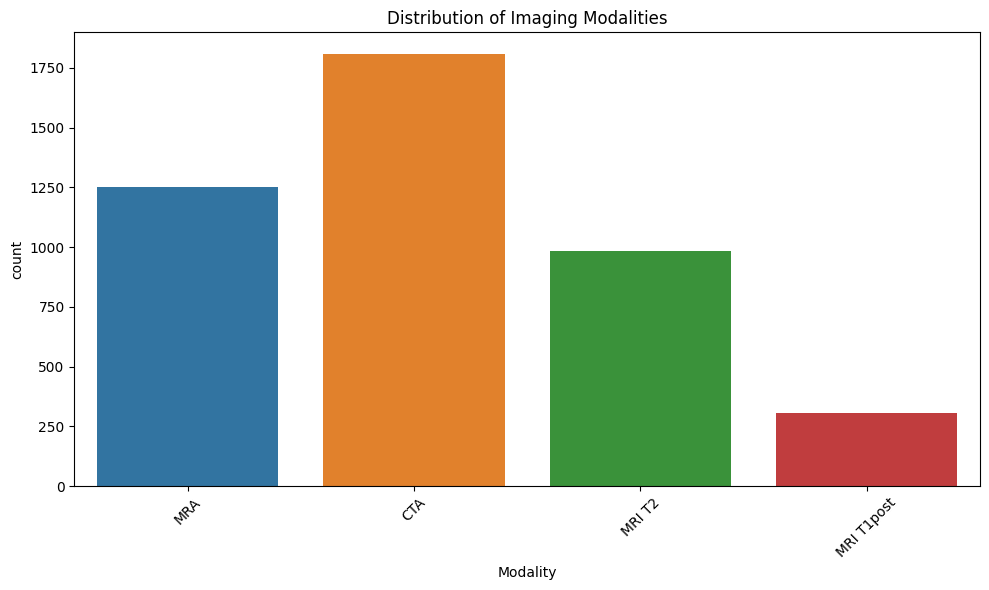

,Total,Aneurysm Count,Aneurysm Rate
Modality,,,
CTA,1808,973,53.816372
MRA,1252,555,44.329073
MRI T2,983,258,26.246185
MRI T1post,305,77,25.245902


In [5]:
# Plot distribution of imaging modalities
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='Modality')
plt.title('Distribution of Imaging Modalities')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check if aneurysm rates differ by modality
modality_aneurysm = train_df.groupby('Modality')['Aneurysm Present'].agg(['count', 'sum', 'mean'])
modality_aneurysm = modality_aneurysm.rename(columns={'count': 'Total', 'sum': 'Aneurysm Count', 'mean': 'Aneurysm Rate'})
modality_aneurysm['Aneurysm Rate'] = modality_aneurysm['Aneurysm Rate'] * 100
display(modality_aneurysm.sort_values('Aneurysm Rate', ascending=False))

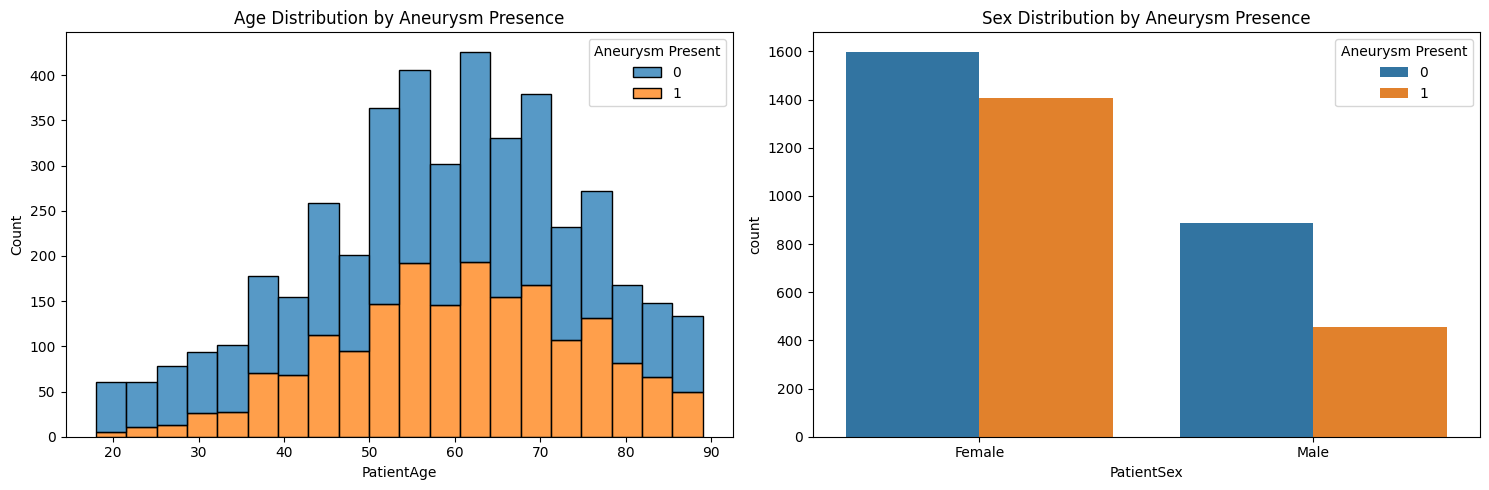

In [6]:
# Analyze demographics
plt.figure(figsize=(15, 5))

# Age distribution
plt.subplot(1, 2, 1)
sns.histplot(data=train_df, x='PatientAge', hue='Aneurysm Present', multiple='stack', bins=20)
plt.title('Age Distribution by Aneurysm Presence')

# Sex distribution
plt.subplot(1, 2, 2)
sns.countplot(data=train_df, x='PatientSex', hue='Aneurysm Present')
plt.title('Sex Distribution by Aneurysm Presence')

plt.tight_layout()
plt.show()

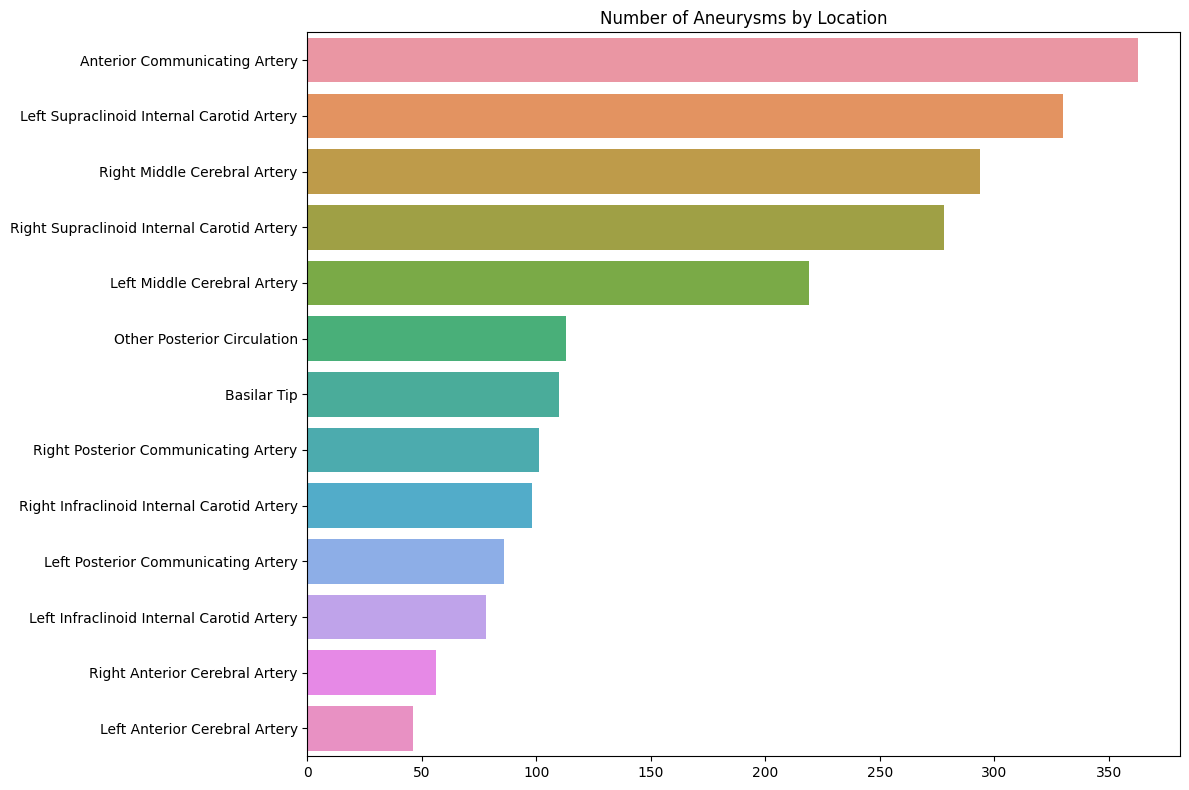

,Count,Percentage
Anterior Communicating Artery,363,19.48
Left Supraclinoid Internal Carotid Artery,330,17.71
Right Middle Cerebral Artery,294,15.78
Right Supraclinoid Internal Carotid Artery,278,14.92
Left Middle Cerebral Artery,219,11.76
Other Posterior Circulation,113,6.07
Basilar Tip,110,5.90
Right Posterior Communicating Artery,101,5.42
Right Infraclinoid Internal Carotid Artery,98,5.26
Left Posterior Communicating Artery,86,4.62


In [7]:
# Analyze aneurysm locations
location_columns = [col for col in train_df.columns if col not in 
                    ['SeriesInstanceUID', 'PatientAge', 'PatientSex', 'Modality', 'Aneurysm Present']]

# Count aneurysms by location
location_counts = train_df[location_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=location_counts.values, y=location_counts.index)
plt.title('Number of Aneurysms by Location')
plt.tight_layout()
plt.show()

# Display percentage of aneurysms by location
total_with_aneurysms = train_df['Aneurysm Present'].sum()
location_percentages = (location_counts / total_with_aneurysms * 100).round(2)
location_df = pd.DataFrame({'Count': location_counts, 'Percentage': location_percentages})
display(location_df)

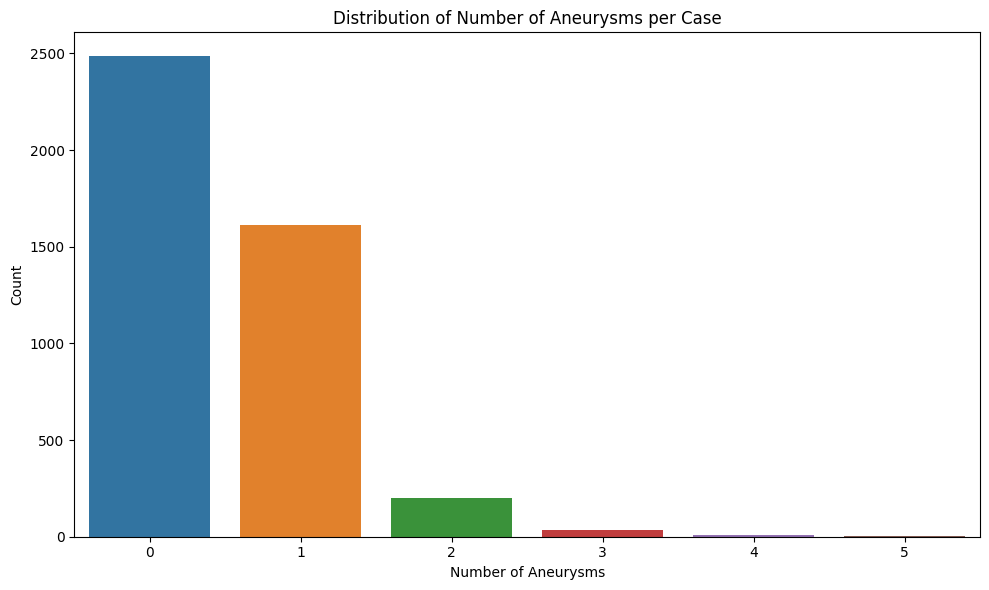

In [8]:
# Check for cases with multiple aneurysms
train_df['Aneurysm Count'] = train_df[location_columns].sum(axis=1)

plt.figure(figsize=(10, 6))
aneurysm_counts = train_df['Aneurysm Count'].value_counts().sort_index()
sns.barplot(x=aneurysm_counts.index, y=aneurysm_counts.values)
plt.title('Distribution of Number of Aneurysms per Case')
plt.xlabel('Number of Aneurysms')
plt.ylabel('Count')
plt.xticks(range(aneurysm_counts.index.max() + 1))
plt.tight_layout()
plt.show()

## 3. Image Data Exploration

In [9]:
# Function to load and display a DICOM series
def load_and_display_dicom_series(series_uid, num_images=6):
    """
    Load and display slices from a DICOM series
    """
    series_path = os.path.join(SERIES_DIR, series_uid)
    
    if not os.path.exists(series_path):
        print(f"Series path not found: {series_path}")
        return
    
    # Get all DICOM files in the series folder
    dicom_files = [os.path.join(series_path, f) for f in os.listdir(series_path) if f.endswith('.dcm')]
    
    # Take a subset of images if there are too many
    if len(dicom_files) > num_images:
        step = len(dicom_files) // num_images
        dicom_files = dicom_files[::step][:num_images]
    
    fig, axes = plt.subplots(1, len(dicom_files), figsize=(20, 4))
    if len(dicom_files) == 1:
        axes = [axes]
    
    for i, file_path in enumerate(dicom_files):
        try:
            dicom = pydicom.dcmread(file_path)
            img_array = dicom.pixel_array
            
            # Apply windowing if available
            if hasattr(dicom, 'WindowCenter') and hasattr(dicom, 'WindowWidth'):
                center = dicom.WindowCenter
                width = dicom.WindowWidth
                if type(center) == pydicom.multival.MultiValue:
                    center = center[0]
                if type(width) == pydicom.multival.MultiValue:
                    width = width[0]
                img_min = center - width // 2
                img_max = center + width // 2
                img_array = np.clip(img_array, img_min, img_max)
            
            # Normalize to 0-1 range for display
            if img_array.max() > img_array.min():
                img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())
            
            axes[i].imshow(img_array, cmap='gray')
            axes[i].set_title(f"Slice {i}")
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            axes[i].text(0.5, 0.5, 'Error loading image', ha='center')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Series: {series_uid}", y=1.05)
    plt.show()


Modality: MRA
Series: 1.2.826.0.1.3680043.8.498.10023411164590664678534044036963716636
Aneurysm locations: Right Middle Cerebral Artery


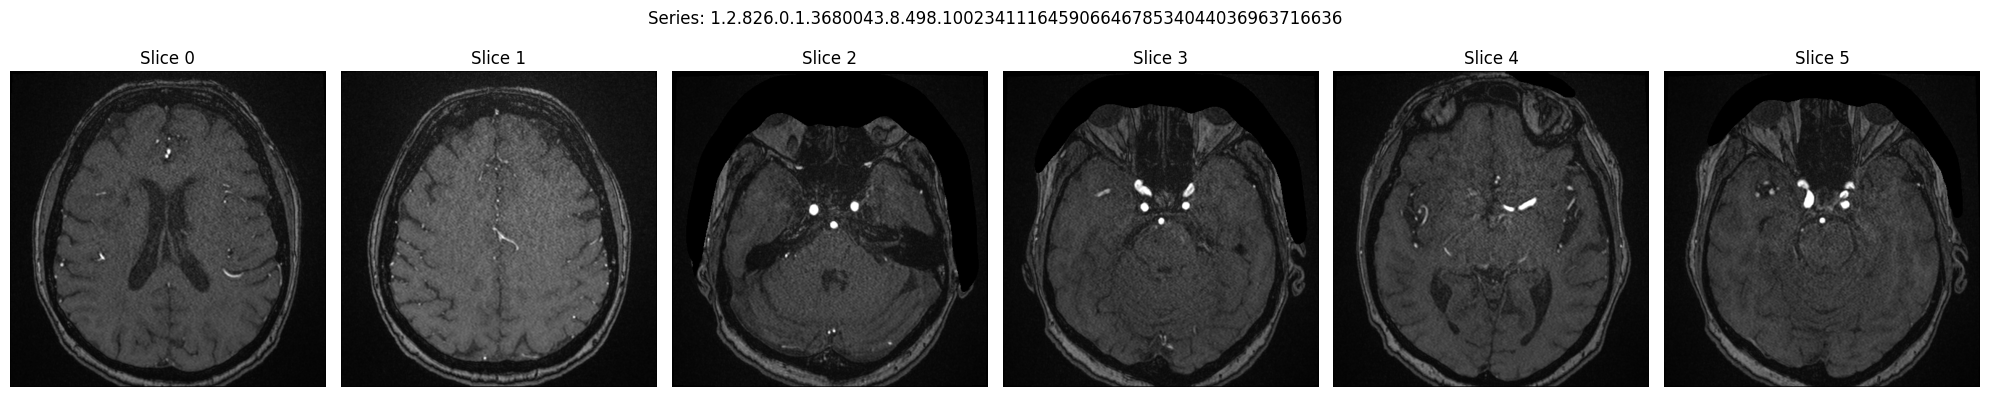


Modality: CTA
Series: 1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317
Aneurysm locations: Other Posterior Circulation


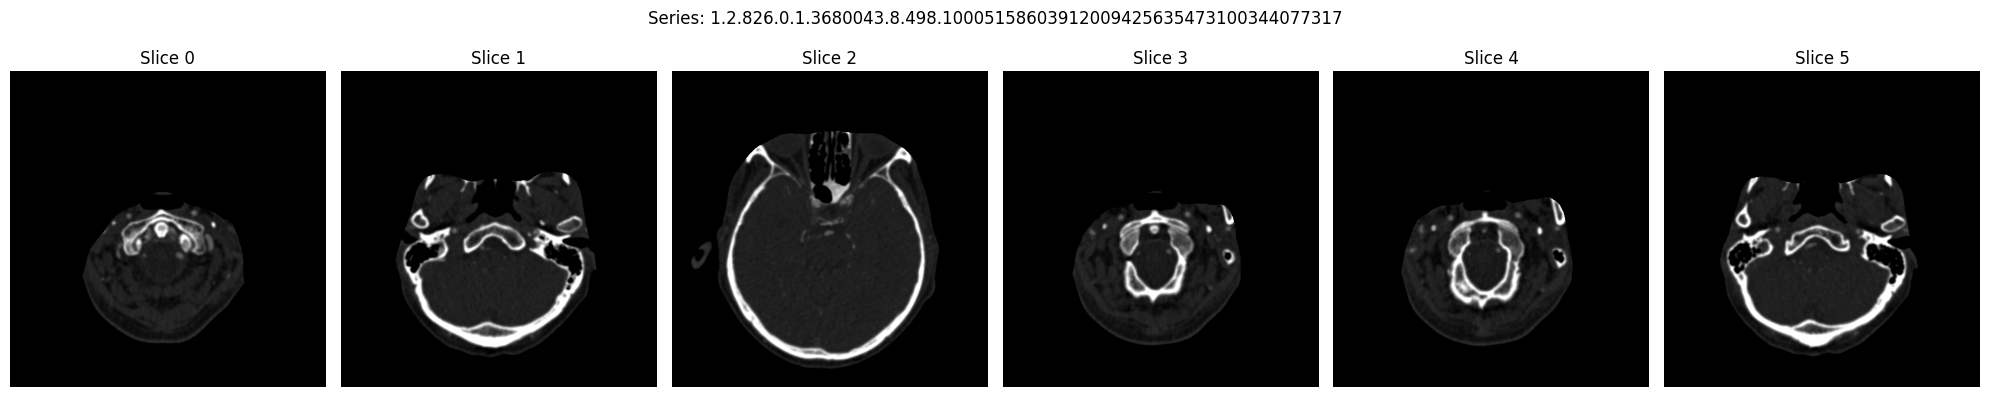


Modality: MRI T2
Series: 1.2.826.0.1.3680043.8.498.10116626135148932224643146695383345963
Aneurysm locations: Right Supraclinoid Internal Carotid Artery


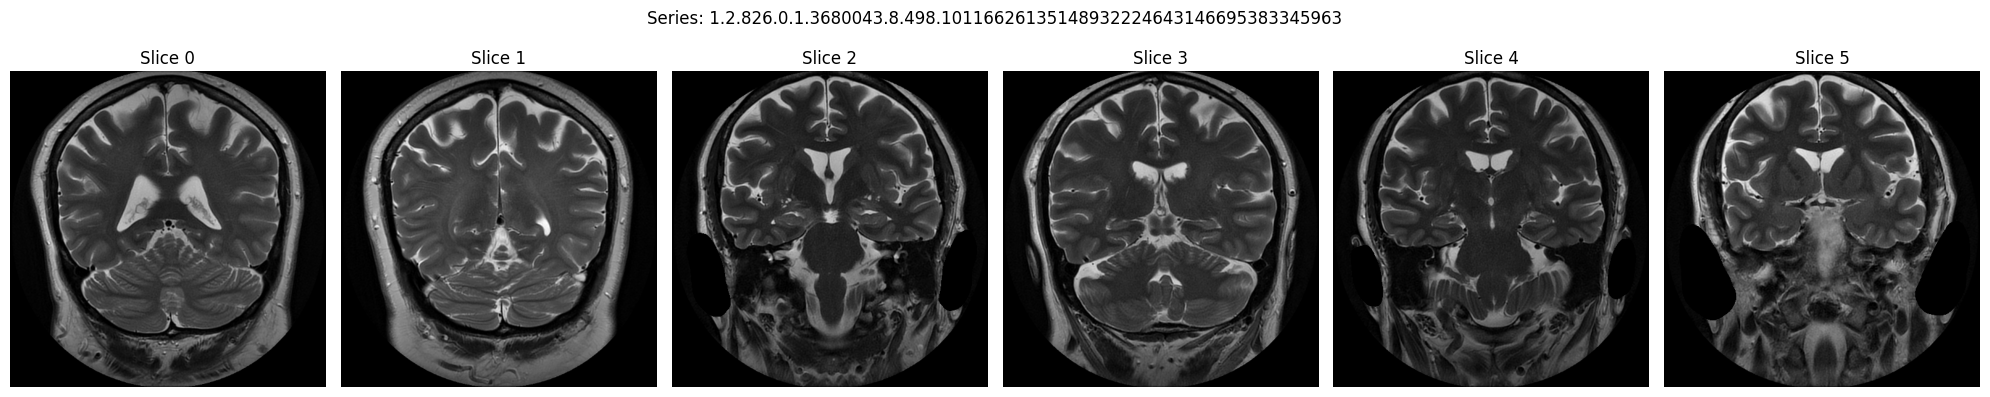


Modality: MRI T1post
Series: 1.2.826.0.1.3680043.8.498.10098743283291956051221530305664415374
Aneurysm locations: Left Anterior Cerebral Artery


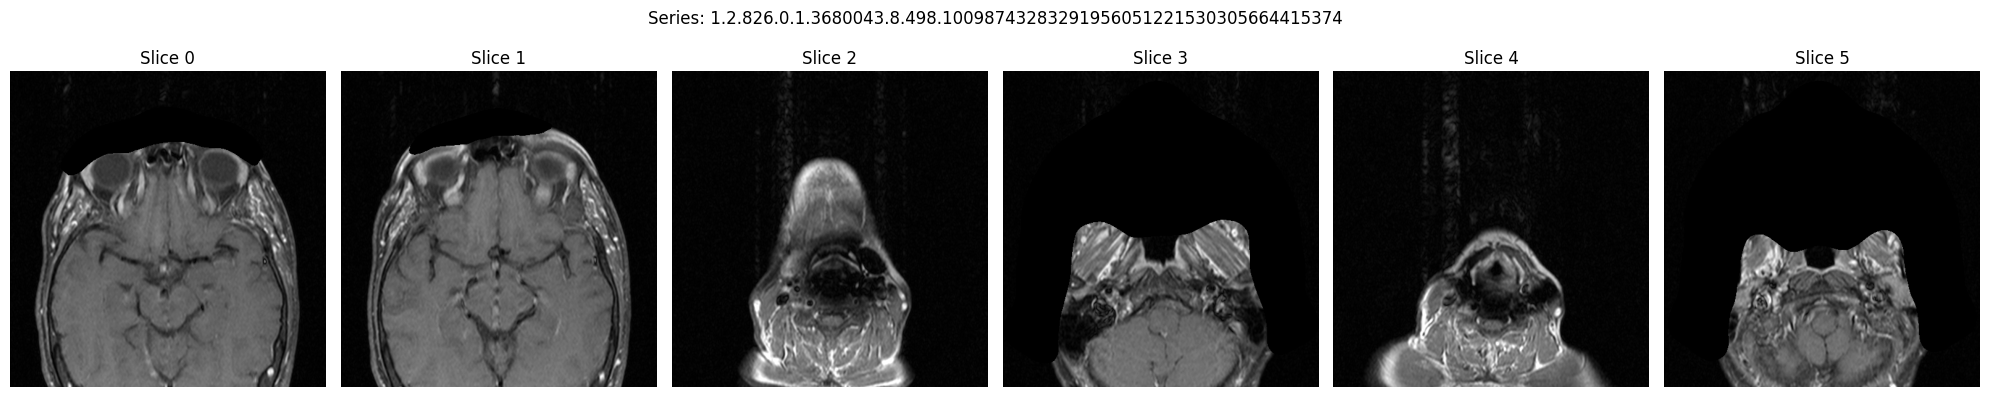

In [10]:
# Get one example of each modality with an aneurysm
modalities = train_df['Modality'].unique()

for modality in modalities:
    # Get a sample with aneurysm for this modality
    sample = train_df[(train_df['Modality'] == modality) & (train_df['Aneurysm Present'] == 1)].iloc[0]
    series_uid = sample['SeriesInstanceUID']
    
    print(f"\nModality: {modality}")
    print(f"Series: {series_uid}")
    print(f"Aneurysm locations: {', '.join([col for col in location_columns if sample[col] == 1])}")
    
    # Load and display the series
    load_and_display_dicom_series(series_uid)

In [11]:
# Let's look at a specific aneurysm case with its localizer data
# Find a case with localizer information
sample_series_uid = localizers_df['SeriesInstanceUID'].iloc[0]
sample_series = train_df[train_df['SeriesInstanceUID'] == sample_series_uid].iloc[0]
sample_localizers = localizers_df[localizers_df['SeriesInstanceUID'] == sample_series_uid]

print(f"Sample series: {sample_series_uid}")
print(f"Modality: {sample_series['Modality']}")
print(f"Patient: Age {sample_series['PatientAge']}, Sex {sample_series['PatientSex']}")
print(f"Aneurysm locations: {', '.join([col for col in location_columns if sample_series[col] == 1])}")
print(f"Number of localizers: {len(sample_localizers)}")
display(sample_localizers.head())

Sample series: 1.2.826.0.1.3680043.8.498.10005158603912009425635473100344077317
Modality: CTA
Patient: Age 58, Sex Male
Aneurysm locations: Other Posterior Circulation
Number of localizers: 1


,SeriesInstanceUID,SOPInstanceUID,coordinates,location
0,1.2.826.0.1.3680043.8.498.10005158603912009425...,1.2.826.0.1.3680043.8.498.10775329348174902199...,"{'x': 258.3621186176837, 'y': 261.359900373599}",Other Posterior Circulation


In [12]:
# Function to display a DICOM image with aneurysm location markers
def display_with_aneurysm_markers(series_uid, localizers_df):
    """
    Display DICOM images with aneurysm location markers
    """
    # Get localizers for this series
    series_localizers = localizers_df[localizers_df['SeriesInstanceUID'] == series_uid]
    if len(series_localizers) == 0:
        print("No localizers found for this series")
        return
    
    series_path = os.path.join(SERIES_DIR, series_uid)
    if not os.path.exists(series_path):
        print(f"Series path not found: {series_path}")
        return
    
    # Group by SOPInstanceUID to handle multiple aneurysms in one image
    grouped_localizers = series_localizers.groupby('SOPInstanceUID')
    
    # Limit to 6 images for display
    sop_ids = list(grouped_localizers.groups.keys())[:6]
    
    fig, axes = plt.subplots(1, len(sop_ids), figsize=(20, 4))
    if len(sop_ids) == 1:
        axes = [axes]
    
    for i, sop_id in enumerate(sop_ids):
        file_path = os.path.join(series_path, f"{sop_id}.dcm")
        
        try:
            # Load DICOM image
            dicom = pydicom.dcmread(file_path)
            img_array = dicom.pixel_array
            
            # Normalize for display
            if img_array.max() > img_array.min():
                img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())
            
            # Display image
            axes[i].imshow(img_array, cmap='gray')
            
            # Get aneurysm coordinates for this image
            image_localizers = grouped_localizers.get_group(sop_id)
            
            # Mark aneurysm locations
            for _, localizer in image_localizers.iterrows():
                coords = eval(localizer['coordinates'])  # Convert string representation to tuple
                axes[i].plot(coords[0], coords[1], 'ro', markersize=10, alpha=0.7)
                axes[i].text(coords[0]+15, coords[1]+15, localizer['location'], 
                           color='red', fontsize=8, backgroundcolor='white')
            
            axes[i].set_title(f"Image: {sop_id[-6:]}")
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            axes[i].text(0.5, 0.5, 'Error loading image', ha='center')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Series: {series_uid} - Aneurysm Locations", y=1.05)
    plt.show()


Location: Middle Cerebral Artery
Series: 1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381
Modality: CTA
Error loading ../input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381/1.2.826.0.1.3680043.8.498.14504961303532677815336995545201912867.dcm: 0
Error loading ../input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381/1.2.826.0.1.3680043.8.498.30083322134992576720636296296008654053.dcm: 0
Error loading ../input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381/1.2.826.0.1.3680043.8.498.46752468449107005352755579756056225731.dcm: 0


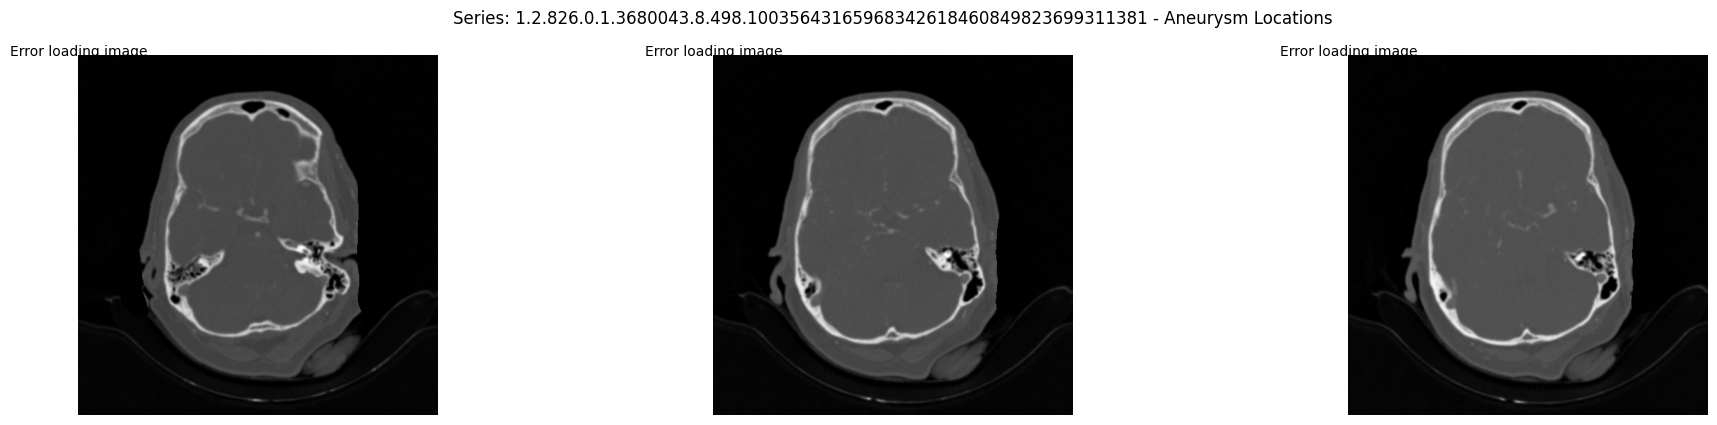


Location: Anterior Communicating Artery
Series: 1.2.826.0.1.3680043.8.498.10034081836061566510187499603024895557
Modality: CTA
Error loading ../input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10034081836061566510187499603024895557/1.2.826.0.1.3680043.8.498.71237104731452368587327801789352569583.dcm: 0


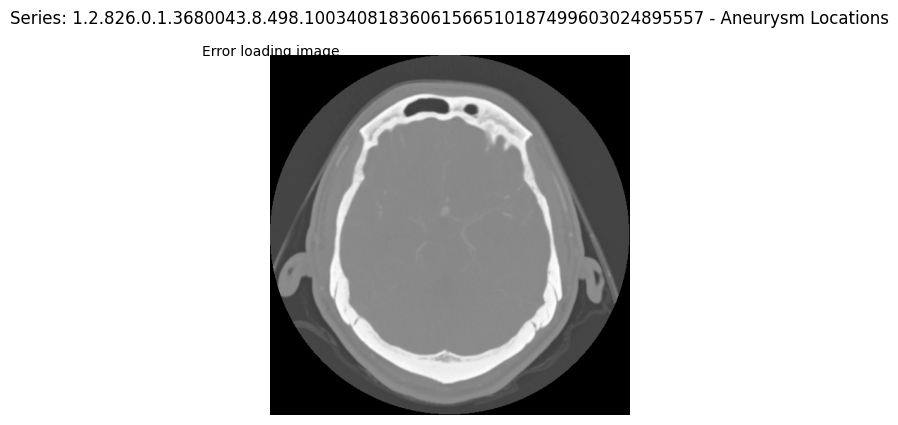


Location: Basilar Tip
Series: 1.2.826.0.1.3680043.8.498.10143240284902513794767720489625125957
Modality: CTA
Error loading ../input/rsna-intracranial-aneurysm-detection/series/1.2.826.0.1.3680043.8.498.10143240284902513794767720489625125957/1.2.826.0.1.3680043.8.498.77238922582709988246272778400362218752.dcm: 0


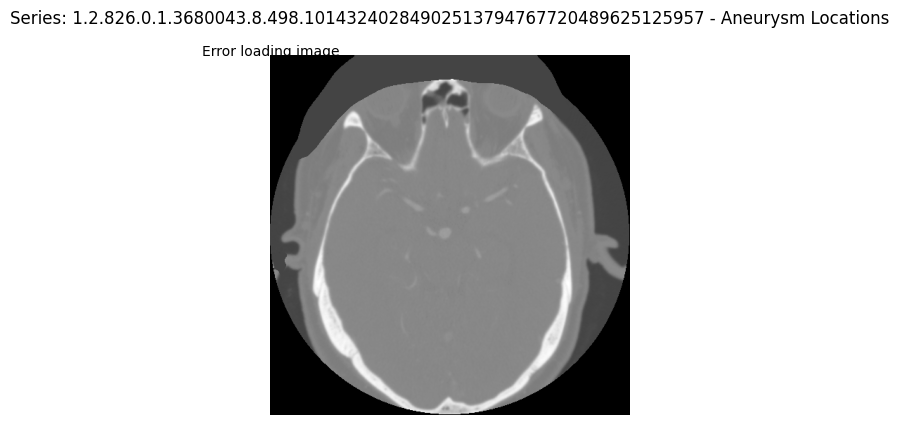

In [13]:
# Display sample cases with aneurysm markers
# Let's look at a few different locations
for location in ['Middle Cerebral Artery', 'Anterior Communicating Artery', 'Basilar Tip'][:3]:
    location_col = [col for col in location_columns if location in col][0]
    
    # Find a series with this location
    sample = train_df[train_df[location_col] == 1].iloc[0]
    series_uid = sample['SeriesInstanceUID']
    
    print(f"\nLocation: {location}")
    print(f"Series: {series_uid}")
    print(f"Modality: {sample['Modality']}")
    
    # Display with markers
    display_with_aneurysm_markers(series_uid, localizers_df)

## 4. Examining Vessel Segmentations

In [14]:
# List available segmentation files
segmentation_files = os.listdir(SEGMENTATIONS_DIR) if os.path.exists(SEGMENTATIONS_DIR) else []
print(f"Number of segmentation files: {len(segmentation_files)}")

# Display mapping of segmentation labels
segmentation_labels = {
    1: 'Other Posterior Circulation',
    2: 'Basilar Tip',
    3: 'Right Posterior Communicating Artery',
    4: 'Left Posterior Communicating Artery',
    5: 'Right Infraclinoid Internal Carotid Artery',
    6: 'Left Infraclinoid Internal Carotid Artery',
    7: 'Right Supraclinoid Internal Carotid Artery',
    8: 'Left Supraclinoid Internal Carotid Artery',
    9: 'Right Middle Cerebral Artery',
    10: 'Left Middle Cerebral Artery',
    11: 'Right Anterior Cerebral Artery',
    12: 'Left Anterior Cerebral Artery',
    13: 'Anterior Communicating Artery'
}

for label, name in segmentation_labels.items():
    print(f"{label}: {name}")

Number of segmentation files: 356
1: Other Posterior Circulation
2: Basilar Tip
3: Right Posterior Communicating Artery
4: Left Posterior Communicating Artery
5: Right Infraclinoid Internal Carotid Artery
6: Left Infraclinoid Internal Carotid Artery
7: Right Supraclinoid Internal Carotid Artery
8: Left Supraclinoid Internal Carotid Artery
9: Right Middle Cerebral Artery
10: Left Middle Cerebral Artery
11: Right Anterior Cerebral Artery
12: Left Anterior Cerebral Artery
13: Anterior Communicating Artery


In [15]:
# Function to display segmentation overlaid on DICOM images
def display_with_segmentation(series_uid, num_slices=4):
    """
    Display DICOM images with vessel segmentation overlay
    """
    # Check if segmentation exists for this series
    seg_file = os.path.join(SEGMENTATIONS_DIR, f"{series_uid}.nii.gz")
    if not os.path.exists(seg_file):
        print(f"No segmentation file found for {series_uid}")
        return
    
    # Load segmentation
    seg_img = nib.load(seg_file)
    seg_data = seg_img.get_fdata()
    
    # Load DICOM series
    series_path = os.path.join(SERIES_DIR, series_uid)
    if not os.path.exists(series_path):
        print(f"Series path not found: {series_path}")
        return
    
    # Get DICOM files and sort by instance number
    dicom_files = [os.path.join(series_path, f) for f in os.listdir(series_path) if f.endswith('.dcm')]
    dicom_instances = []
    for file in dicom_files:
        try:
            ds = pydicom.dcmread(file)
            dicom_instances.append((file, ds.InstanceNumber))
        except:
            continue
    
    dicom_instances.sort(key=lambda x: x[1])
    dicom_files = [x[0] for x in dicom_instances]
    
    # Find slices with segmentation
    has_segmentation = []
    for i in range(seg_data.shape[2]):
        if np.any(seg_data[:,:,i] > 0):
            has_segmentation.append(i)
    
    if not has_segmentation:
        print("No segmentation found in any slice")
        return
    
    # Select slices to display
    if len(has_segmentation) > num_slices:
        step = len(has_segmentation) // num_slices
        slices_to_show = has_segmentation[::step][:num_slices]
    else:
        slices_to_show = has_segmentation
    
    # Display slices with segmentation overlay
    fig, axes = plt.subplots(1, len(slices_to_show), figsize=(20, 5))
    if len(slices_to_show) == 1:
        axes = [axes]
    
    for i, slice_idx in enumerate(slices_to_show):
        if slice_idx >= len(dicom_files):
            axes[i].text(0.5, 0.5, 'Slice index out of range', ha='center')
            axes[i].axis('off')
            continue
            
        try:
            # Load DICOM image
            dicom = pydicom.dcmread(dicom_files[slice_idx])
            img_array = dicom.pixel_array.astype(float)
            
            # Normalize for display
            if img_array.max() > img_array.min():
                img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())
            
            # Get segmentation slice
            seg_slice = seg_data[:,:,slice_idx]
            
            # Create RGB image
            rgb_img = np.stack([img_array, img_array, img_array], axis=2)
            
            # Add colored overlay for different vessel segments
            for label in np.unique(seg_slice):
                if label == 0:  # Skip background
                    continue
                    
                # Choose color based on label
                if label <= 4:  # Posterior circulation - red
                    color = [1, 0, 0]
                elif label <= 8:  # Carotid arteries - blue
                    color = [0, 0, 1]
                else:  # Anterior circulation - green
                    color = [0, 1, 0]
                
                # Apply color mask
                mask = seg_slice == label
                for c in range(3):
                    rgb_img[:,:,c] = np.where(mask, color[c], rgb_img[:,:,c])
            
            axes[i].imshow(rgb_img)
            axes[i].set_title(f"Slice {slice_idx}")
            axes[i].axis('off')
        except Exception as e:
            print(f"Error processing slice {slice_idx}: {e}")
            axes[i].text(0.5, 0.5, f'Error: {str(e)[:20]}...', ha='center')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Series: {series_uid} - Vessel Segmentation Overlay", y=1.05)
    plt.show()

In [16]:
# Find series with segmentation files
segmented_series = [f.split('.')[0] for f in segmentation_files[:5]]  # limit to 5 examples

for series_uid in segmented_series:
    # Get information about this series
    if series_uid in train_df['SeriesInstanceUID'].values:
        series_info = train_df[train_df['SeriesInstanceUID'] == series_uid].iloc[0]
        print(f"\nSeries: {series_uid}")
        print(f"Modality: {series_info['Modality']}")
        print(f"Aneurysm Present: {'Yes' if series_info['Aneurysm Present'] == 1 else 'No'}")
        
        # Display segmentation overlay
        display_with_segmentation(series_uid)

## 5. Building a Simple Baseline Model

For this competition, we would typically build a 3D CNN or a model that can process entire image series. However, as a simpler starting point, let's extract basic features from the DICOM metadata and train a classifier.

In [17]:
# Extract metadata features
def extract_metadata_features(df):
    # Copy original dataframe to avoid modifying it
    df_features = df.copy()
    
    # Encode categorical variables
    df_features = pd.get_dummies(df_features, columns=['Modality', 'PatientSex'], drop_first=False)
    
    # Scale age
    df_features['PatientAge'] = df_features['PatientAge'] / 100.0
    
    # Drop the ID column
    df_features = df_features.drop('SeriesInstanceUID', axis=1)
    
    return df_features

In [18]:
# Prepare data for modeling
features_df = extract_metadata_features(train_df)

# Define target and features
target = features_df['Aneurysm Present']
features = features_df.drop(['Aneurysm Present'] + location_columns + ['Aneurysm Count'], axis=1)

print("Features:")
print(features.columns.tolist())
print(f"Number of features: {features.shape[1]}")

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Features:
['PatientAge', 'Modality_CTA', 'Modality_MRA', 'Modality_MRI T1post', 'Modality_MRI T2', 'PatientSex_Female', 'PatientSex_Male']
Number of features: 7
Training set: 3478 samples
Validation set: 870 samples


AUC-ROC: 0.6267


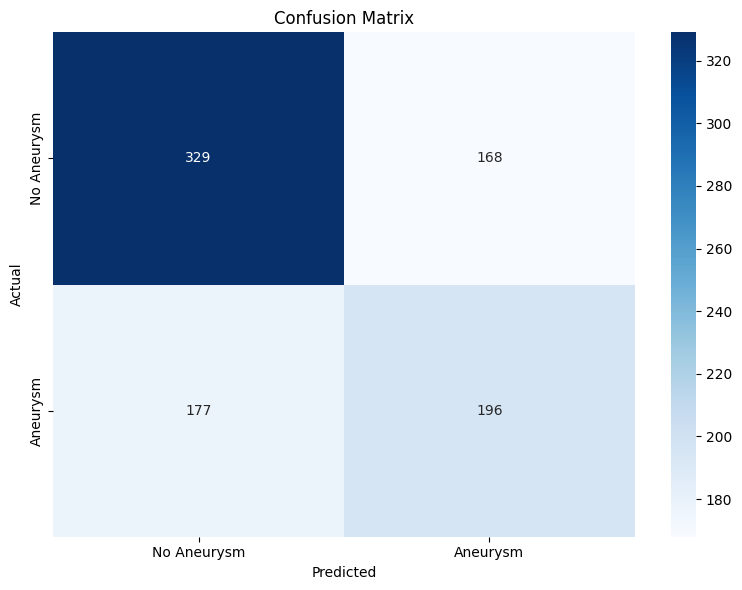


Classification Report:
              precision    recall  f1-score   support

 No Aneurysm       0.65      0.66      0.66       497
    Aneurysm       0.54      0.53      0.53       373

    accuracy                           0.60       870
   macro avg       0.59      0.59      0.59       870
weighted avg       0.60      0.60      0.60       870



In [19]:
# Train a simple model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred_proba = model.predict_proba(X_val)[:, 1]
y_pred = model.predict(X_val)

# Evaluate performance
auc = roc_auc_score(y_val, y_pred_proba)
print(f"AUC-ROC: {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Aneurysm", "Aneurysm"], 
            yticklabels=["No Aneurysm", "Aneurysm"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["No Aneurysm", "Aneurysm"]))

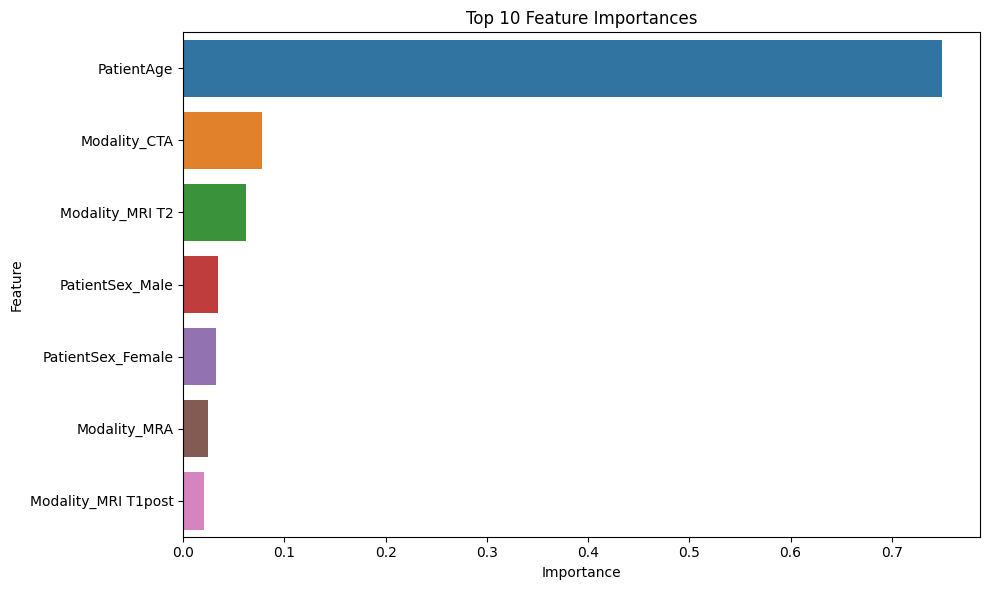

In [20]:
# Feature importance
feature_importances = pd.DataFrame({
    'Feature': features.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

## 6. Conclusions and Next Steps

In this notebook, we've performed a basic exploratory data analysis of the RSNA Intracranial Aneurysm Detection competition data and built a simple metadata-based classifier. However, this is just a starting point and doesn't utilize the rich imaging data available.

**Key findings:**
1. The dataset contains different imaging modalities (CTA, MRA, MRI)
2. There's class imbalance with fewer cases having aneurysms than not
3. Aneurysms occur in various locations with different frequencies
4. Some cases have multiple aneurysms
5. The metadata alone doesn't provide strong predictive power

**Next steps to improve performance:**

1. **Image preprocessing:**
   - Standardize orientation and spacing
   - Apply windowing based on modality
   - Create 3D volumes from 2D slices

2. **Deep learning approaches:**
   - Implement 3D CNN architectures (e.g., 3D ResNet, 3D UNet)
   - Consider pre-trained models on similar medical datasets
   - Explore transfer learning from natural image domains

3. **Utilize additional data:**
   - Incorporate vessel segmentations as input or for data augmentation
   - Use localizer data for focused region attention

4. **Address class imbalance:**
   - Apply over/undersampling techniques
   - Use weighted loss functions
   - Implement data augmentation strategies

5. **Ensemble methods:**
   - Train separate models for different modalities
   - Combine predictions from multiple architectures

The real challenge of this competition is in accurately detecting and localizing aneurysms from the 3D imaging data, which will require more sophisticated deep learning approaches than what we've demonstrated in this introductory notebook.

### Connect with Me  

Feel free to follow me on these platforms:  

[![GitHub](https://img.shields.io/badge/GitHub-181717?style=for-the-badge&logo=github&logoColor=white)](https://github.com/AdilShamim8)  
[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/adilshamim8)  
[![Twitter](https://img.shields.io/badge/Twitter-1DA1F2?style=for-the-badge&logo=twitter&logoColor=white)](https://x.com/adil_shamim8)  